In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import sys
import glob
import re
import pickle
import random

import wave
import librosa as lb
import librosa.display as lbd
from python_speech_features import *
import soundfile as sf
import io
from IPython.display import Audio

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import ast

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Embedding, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

from sklearn.model_selection import train_test_split

2025-07-27 23:43:06.899383: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 23:43:06.900297: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 23:43:06.904931: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 23:43:06.917425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753639986.941294  103948 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753639986.94

cpu


In [3]:
df = pd.read_csv('audio_features.csv')
df_b = pd.read_csv('audio_balanced.csv')
df_77 = pd.read_csv('audio_balanced_77.csv')
train_df_balanced = pd.read_csv('train_balanced.csv')
test_df_balanced = pd.read_csv('test_balanced.csv')
df_bdown = pd.read_csv('audio_balanced_downsampled.csv')
train_df_bdown = pd.read_csv('train_balanced_downsampled.csv')
test_df_bdown = pd.read_csv('test_balanced_downsampled.csv')

# print table for sizes of df, df_balanced, df_balanced_downsampled, df_77, train_df_balanced, test_df_balanced, train_df_bdown, test_df_bdown
sizes_table = pd.DataFrame({
    'DataFrame': ['df', 'df_balanced', 'df_balanced_downsampled', 'df_77', 'train_df_balanced', 'test_df_balanced', 'train_df_bdown', 'test_df_bdown'],
    'No. of Samples': [len(df), len(df_b), len(df_bdown), len(df_77), len(train_df_balanced), len(test_df_balanced), len(train_df_bdown), len(test_df_bdown)]
})

sizes_table = sizes_table.set_index('DataFrame')
sizes_table = sizes_table.reset_index()
sizes_table = sizes_table.style.set_properties(**{'text-align': 'left'})
sizes_table = sizes_table.set_table_attributes('class="table table-striped"')
sizes_table = sizes_table.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
sizes_table

,DataFrame,No. of Samples
0,df,196
1,df_balanced,306
2,df_balanced_downsampled,86
3,df_77,154
4,train_df_balanced,232
5,test_df_balanced,74
6,train_df_bdown,64
7,test_df_bdown,22


In [4]:
def get_train_test_split(df, val, reshape_val):
    ''' 
    df is a DataFrame with a 'Features' column containing string representations of numpy arrays.
    val is the test size for train_test_split.
    resshape val is like (-1, 1, 256) or (-1, 256) depending on the model input shape. thus it is a tuple.
    '''
    if type(df['Features'].iloc[0]) == str:
        df['Features'] = df['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
        
    X = np.stack(df['Features'].values)
    print("X shape before reshape:", X.shape)
    X = X.reshape(reshape_val)
    y = df['PHQ_Binary'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val, random_state=44)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    print("Train and Test Split:" f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")
    return X_train, X_test, y_train, y_test
    
    

In [5]:
if type(df_b['Features'].iloc[0]) == str:
    df_b['Features'] = df_b['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
X = np.stack(df_b['Features'].values)
print("X shape before reshape:", X.shape)
# X = X.reshape(-1, 1, 256)
X = X.reshape(-1, 16, 16)
y = df_b['PHQ_Binary'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=44)
print("Train and Test Split for Balanced:" f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

X shape before reshape: (306, 256)
Train and Test Split for Balanced:(244, 16, 16), (62, 16, 16), (244,), (62,)


In [6]:
X_train77, X_test77, y_train77, y_test77 = get_train_test_split(df_77, 0.2, (-1, 16, 16))
X_trainD, X_testD, y_trainD, y_testD = get_train_test_split(df_bdown, 0.2, (-1, 16, 16))

X shape before reshape: (154, 256)
Train and Test Split:(123, 16, 16), (31, 16, 16), (123,), (31,)
X shape before reshape: (86, 256)
Train and Test Split:(68, 16, 16), (18, 16, 16), (68,), (18,)


In [7]:
# evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")    
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    

In [8]:
# plot graph of accuracy and loss over time in same figure
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Accuracy and Loss')
    plt.xlabel('Epochs')

### GRU 32, 16, (1, 256), None

In [9]:
model = Sequential()
model.add(GRU(64, input_shape=(16, 16), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-07-27 23:43:11.714722: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        15,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,857 (69.75 KB)

 Trainable params: 17,857 (69.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
epochs = [10, 50, 100]

#### 1. Upsampled Balanced Dataset 

Training for 10 epochs
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5268 - loss: 0.6922 - val_accuracy: 0.5645 - val_loss: 0.6888
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4913 - loss: 0.6908 - val_accuracy: 0.5806 - val_loss: 0.6862
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6061 - loss: 0.6817 - val_accuracy: 0.5806 - val_loss: 0.6836
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5484 - loss: 0.6865 - val_accuracy: 0.5968 - val_loss: 0.6810
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6581 - loss: 0.6735 - val_accuracy: 0.5806 - val_loss: 0.6773
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5904 - loss: 0.6747 - val_accuracy: 0.5968 - val_loss: 0.6725
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6164 - loss: 0.6758 - val_accuracy: 0.6129 - val_loss: 0.6678
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6385 - loss: 0.6716 - val_accuracy: 0.6

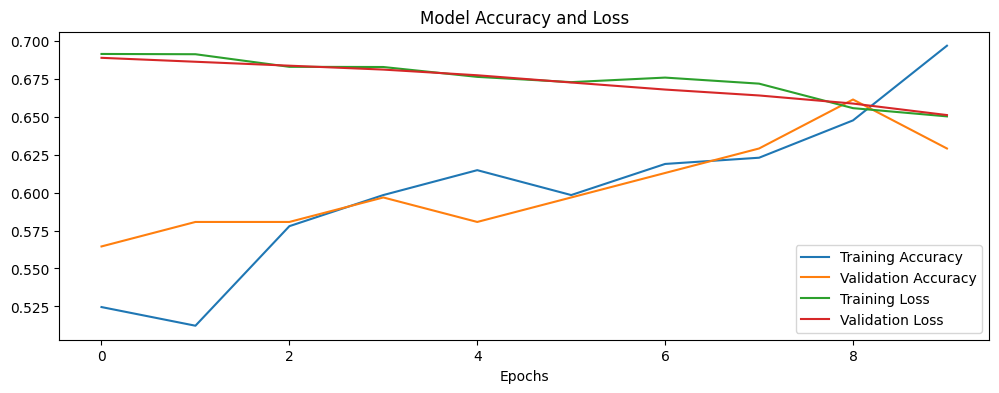

Training for 50 epochs
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5290 - loss: 0.6907 - val_accuracy: 0.5323 - val_loss: 0.6864
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5163 - loss: 0.6912 - val_accuracy: 0.5806 - val_loss: 0.6833
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5678 - loss: 0.6847 - val_accuracy: 0.6290 - val_loss: 0.6794
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6253 - loss: 0.6773 - val_accuracy: 0.6129 - val_loss: 0.6762
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5886 - loss: 0.6790 - val_accuracy: 0.6452 - val_loss: 0.6736
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6229 - loss: 0.6708 - val_accuracy: 0.6290 - val_loss: 0.6706
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6608 - loss: 0.6651 - val_accuracy: 0.6290 - val_loss: 0.6683
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6183 - loss: 0.6623 - val_accuracy: 0.6

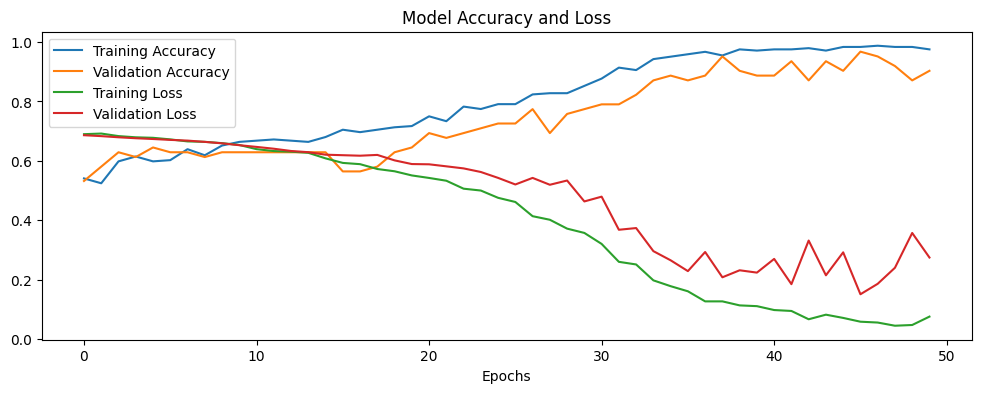

Training for 100 epochs
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4934 - loss: 0.6955 - val_accuracy: 0.5806 - val_loss: 0.6905
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5711 - loss: 0.6889 - val_accuracy: 0.6129 - val_loss: 0.6878
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6056 - loss: 0.6838 - val_accuracy: 0.6613 - val_loss: 0.6852
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6085 - loss: 0.6855 - val_accuracy: 0.6452 - val_loss: 0.6829
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6756 - loss: 0.6761 - val_accuracy: 0.5968 - val_loss: 0.6800
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6358 - loss: 0.6731 - val_accuracy: 0.6935 - val_loss: 0.6761
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6398 - loss: 0.6733 - val_accuracy: 0.6935 - val_loss: 0.6722
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6109 - loss: 0.6652 - val_accu

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7b98d430f100> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step
Accuracy: 0.8226
Precision: 0.7317
Recall: 1.0000
F1 Score: 0.8451


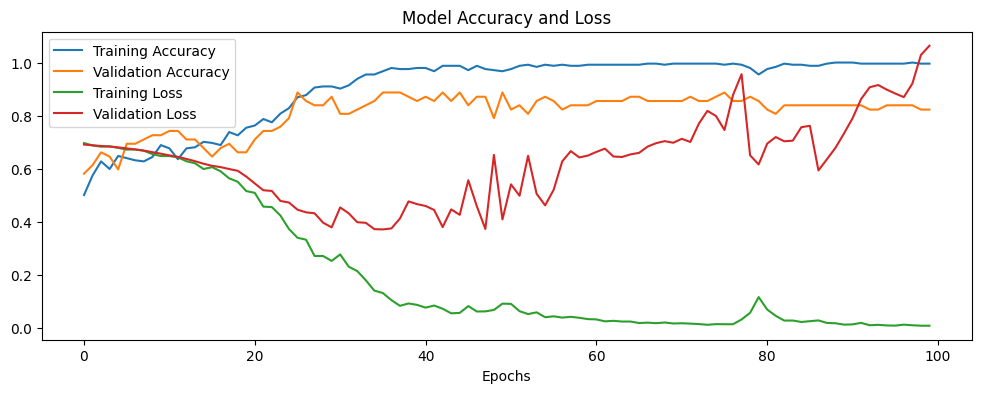

In [11]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    model = Sequential()
    model.add(GRU(64, input_shape=(16, 16), return_sequences=False))  # single time step
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_test, y_test))
    evaluate_model(model, X_test, y_test)
    
    # Plot the training history
    plot_history(history)
    plt.show()
    
    model.save(f'saved_models/gru_model_{epoch}_32_16_1616.h5')

#### 2. 77 of each class

Training for 10 epochs
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.4453 - loss: 0.6913 - val_accuracy: 0.5161 - val_loss: 0.6899
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5001 - loss: 0.6895 - val_accuracy: 0.5161 - val_loss: 0.6866
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5421 - loss: 0.6889 - val_accuracy: 0.5161 - val_loss: 0.6837
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6411 - loss: 0.6797 - val_accuracy: 0.5161 - val_loss: 0.6808
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6721 - loss: 0.6758 - val_accuracy: 0.5484 - val_loss: 0.6775
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6495 - loss: 0.6694 - val_accuracy: 0.5645 - val_loss: 0.6736
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6877 - loss: 0.6624 - val_accuracy: 0.5806 - val_loss: 0.6694
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5715 - loss: 0.6728 - val_accuracy: 0.5

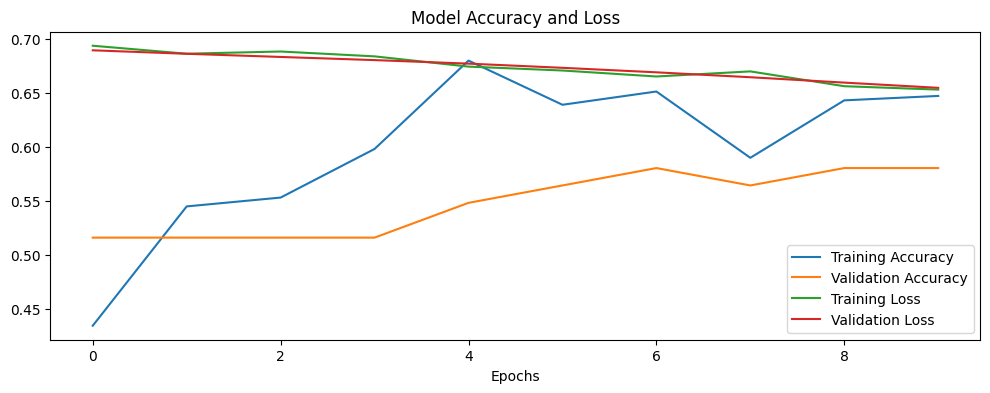

Training for 50 epochs
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5081 - loss: 0.6921 - val_accuracy: 0.5968 - val_loss: 0.6857
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5650 - loss: 0.6859 - val_accuracy: 0.6613 - val_loss: 0.6825
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5767 - loss: 0.6812 - val_accuracy: 0.6774 - val_loss: 0.6790
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5988 - loss: 0.6762 - val_accuracy: 0.6935 - val_loss: 0.6753
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6251 - loss: 0.6737 - val_accuracy: 0.6774 - val_loss: 0.6719
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6038 - loss: 0.6714 - val_accuracy: 0.6452 - val_loss: 0.6682
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6793 - loss: 0.6573 - val_accuracy: 0.6613 - val_loss: 0.6631
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6505 - loss: 0.6590 - val_accuracy: 0.6

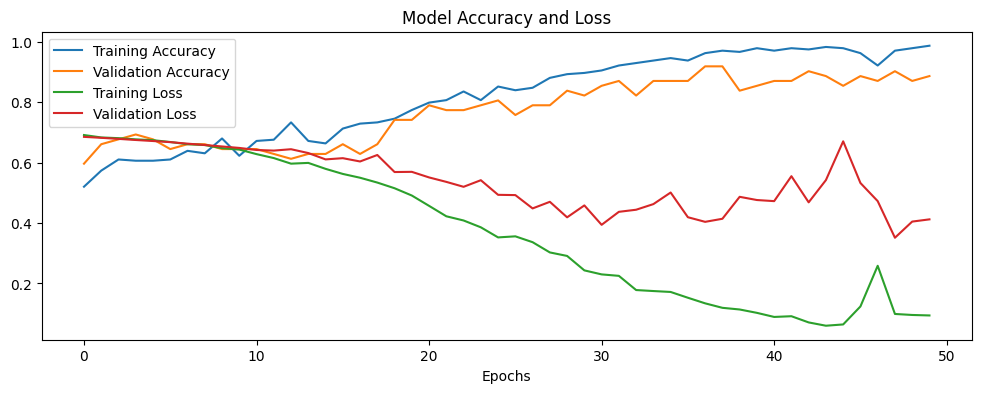

Training for 100 epochs
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5204 - loss: 0.6936 - val_accuracy: 0.5968 - val_loss: 0.6847
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4616 - loss: 0.6938 - val_accuracy: 0.6452 - val_loss: 0.6815
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5103 - loss: 0.6864 - val_accuracy: 0.6935 - val_loss: 0.6781
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6173 - loss: 0.6762 - val_accuracy: 0.6774 - val_loss: 0.6739
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6922 - loss: 0.6686 - val_accuracy: 0.6935 - val_loss: 0.6689
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6460 - loss: 0.6705 - val_accuracy: 0.7097 - val_loss: 0.6640
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6685 - loss: 0.6578 - val_accuracy: 0.6774 - val_loss: 0.6586
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6924 - loss: 0.6546 - val_accu

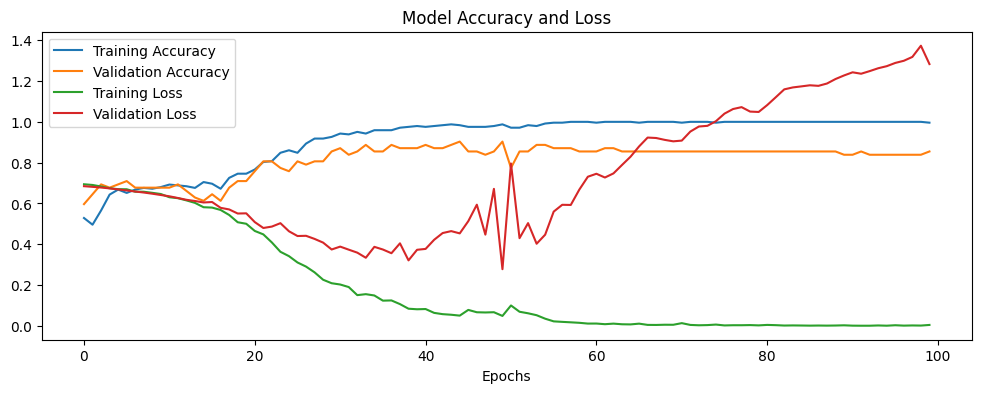

In [12]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    model = Sequential()
    model.add(GRU(64, input_shape=(16, 16), return_sequences=False))  # single time step
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_test, y_test))
    
    # Evaluate the model
    evaluate_model(model, X_test, y_test)
    
    # Plot the training history
    plot_history(history)
    plt.show()
    
    # Save the model
    model.save(f'saved_models/gru_model_{epoch}_77_32_16_1616.h5')

#### 3. Downsampled Balanced Dataset

Training for 10 epochs


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                     │ (None, 64)             │        15,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,857 (69.75 KB)

 Trainable params: 17,857 (69.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5171 - loss: 0.6925 - val_accuracy: 0.5484 - val_loss: 0.6879
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5354 - loss: 0.6899 - val_accuracy: 0.6129 - val_loss: 0.6823
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5526 - loss: 0.6868 - val_accuracy: 0.6129 - val_loss: 0.6763
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5993 - loss: 0.6783 - val_accuracy: 0.6129 - val_loss: 0.6718
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7044 - loss: 0.6581 - val_accuracy: 0.5968 - val_loss: 0.6644
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6159 - loss: 0.6649 - val_accuracy: 0.5806 - val_loss: 0.6582
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6901 - loss: 0.6509 - val_accuracy: 0.5968 - val_loss: 0.6501
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6772 - loss: 0.6463 - val_accuracy: 0.6129 - v

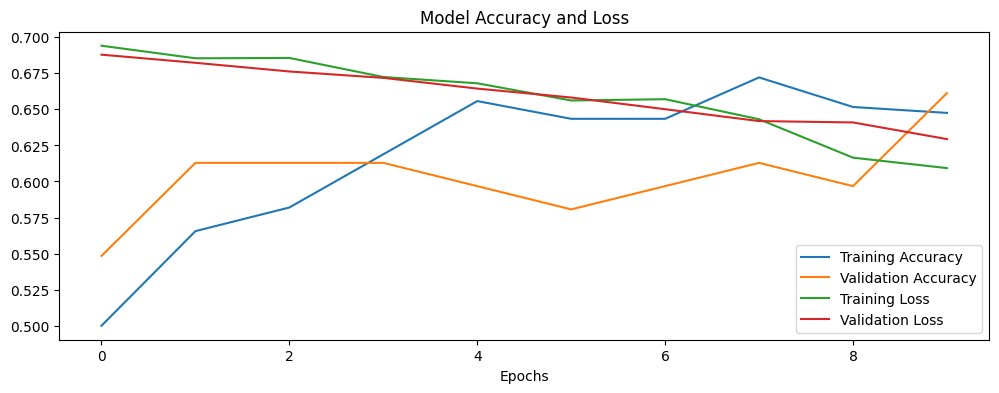

Training for 50 epochs


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 64)             │        15,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,857 (69.75 KB)

 Trainable params: 17,857 (69.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5105 - loss: 0.6950 - val_accuracy: 0.5161 - val_loss: 0.6949
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5264 - loss: 0.6870 - val_accuracy: 0.5484 - val_loss: 0.6907
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6274 - loss: 0.6803 - val_accuracy: 0.5484 - val_loss: 0.6873
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5693 - loss: 0.6797 - val_accuracy: 0.5806 - val_loss: 0.6839
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6098 - loss: 0.6747 - val_accuracy: 0.6452 - val_loss: 0.6796
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6435 - loss: 0.6647 - val_accuracy: 0.6290 - val_loss: 0.6739
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6748 - loss: 0.6543 - val_accuracy: 0.6774 - val_loss: 0.6664
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6709 - loss: 0.6589 - val_accuracy: 0.6774 - v

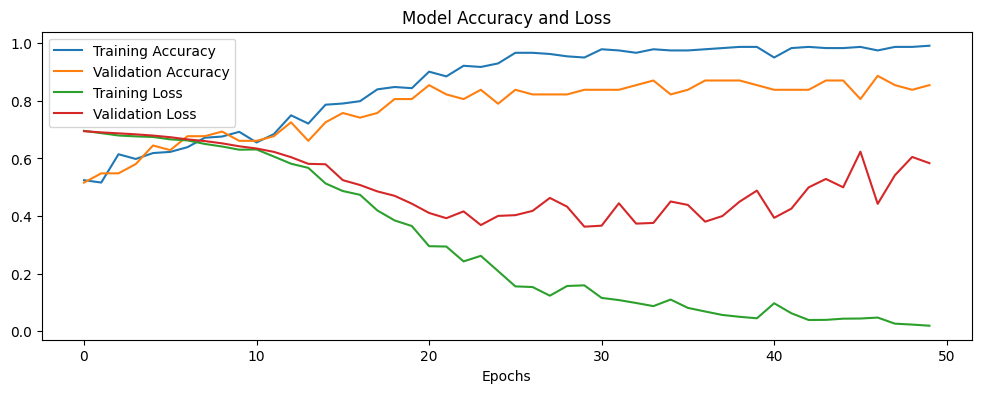

Training for 100 epochs


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_9 (GRU)                     │ (None, 64)             │        15,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,857 (69.75 KB)

 Trainable params: 17,857 (69.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.4912 - loss: 0.6934 - val_accuracy: 0.5323 - val_loss: 0.6848
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5256 - loss: 0.6866 - val_accuracy: 0.6452 - val_loss: 0.6805
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5741 - loss: 0.6822 - val_accuracy: 0.7097 - val_loss: 0.6765
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5968 - loss: 0.6823 - val_accuracy: 0.6935 - val_loss: 0.6700
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6607 - loss: 0.6666 - val_accuracy: 0.6935 - val_loss: 0.6637
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6406 - loss: 0.6649 - val_accuracy: 0.7097 - val_loss: 0.6547
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6337 - loss: 0.6608 - val_accuracy: 0.6935 - val_loss: 0.6473
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5772 - loss: 0.6594 - val_accuracy: 0.

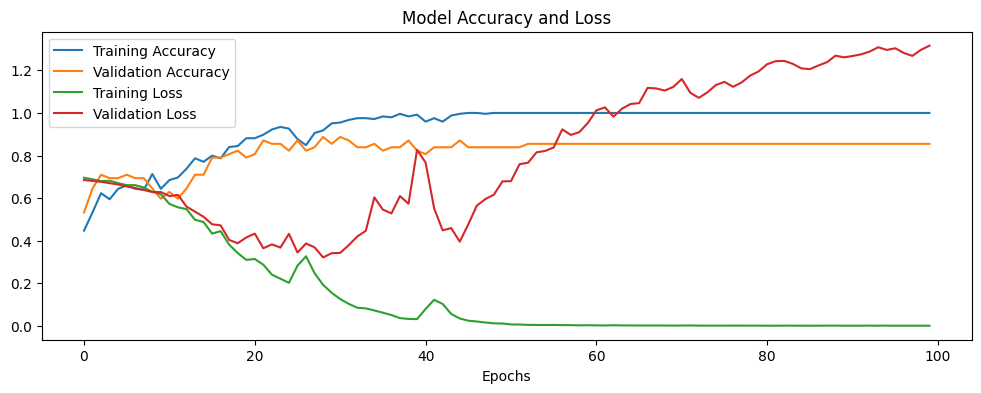

In [13]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    model = Sequential()
    model.add(GRU(64, input_shape=(16, 16), return_sequences=False))  # single time step
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # binary classification
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    # history = model.fit(X_trainD, y_trainD, epochs=epoch, batch_size

    history = model.fit(X_train, y_train, epochs=epoch, batch_size=16, validation_data=(X_test, y_test))
    
    # Evaluate the model
    evaluate_model(model, X_test, y_test)
    
    # Plot the training history
    plot_history(history)
    plt.show()
    
    # Save the model
    model.save(f'saved_models/gru_model_{epoch}_epochs.h5')  